In [1]:
from src.phishIRISData import PhishIRISData
from src.config import config
from sklearn.model_selection import train_test_split

from src.SIFT_bovw import (read_bw_images, sift_features, get_visual_words, get_frequency_vectors, get_tfidf,
                           search_test)


import joblib

In [2]:
data = PhishIRISData().get_data()

In [3]:
k, codebook = joblib.load(config.PROCESSED_DATA_DIR / "bovw-codebook.pkl")

In [4]:
images_training, images_testing, labels_training, labels_testing = train_test_split(data.imgs, data.labels, test_size=0.2, random_state=42)

In [5]:
bw_images_train, bw_images_test = read_bw_images(images_training), read_bw_images(images_testing)

In [6]:
keypoints_train, descriptors_train = sift_features(bw_images_train) 
keypoints_test, descriptors_test = sift_features(bw_images_test)

len before: 730
indexes: []
len after: 730
len before: 183
indexes: []
len after: 183


In [7]:
joblib.dump(descriptors_train, config.PROCESSED_DATA_DIR / "bovw-train.pkl")
joblib.dump(descriptors_test, config.PROCESSED_DATA_DIR / "bovw-test.pkl")

['/Users/marcinjarczewski/src/phish-target-recognition/data/processed/bovw-test.pkl']

In [8]:
descriptors_train = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")
descriptors_test = joblib.load(config.PROCESSED_DATA_DIR / "bovw-test.pkl")

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_test = get_visual_words(descriptors_test, codebook)

In [9]:
frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_test = get_frequency_vectors(visual_words_test, k)

In [10]:
tfidf_train = get_tfidf(frequency_vectors_train)
tfidf_test = get_tfidf(frequency_vectors_test)

df.shape, df[:5]: (200,), [420 667 612 342 572]
idf.shape, idf[:5]: (200,), [0.55278982 0.09025449 0.17631225 0.7582338  0.24390554]
df.shape, df[:5]: (200,), [119 171 166 108 159]
idf.shape, idf[:5]: (200,), [0.43036266 0.0678226  0.09749836 0.52735493 0.14058195]


In [10]:
search_test(tfidf_test[0], tfidf_train)

(array([230, 272, 401, 497,  67]),
 array([0.95344589, 0.84928545, 0.84928545, 0.82783401, 0.82643332]))

In [11]:
print(labels_testing[0])
for idx, el in enumerate([230,272,401,497,67]):
    print(f"{idx}: {labels_training[el]}")

facebook
0: facebook
1: wellsfargo
2: wellsfargo
3: linkedin
4: linkedin


In [11]:
k1, d1 = sift_features([bw_images_test[15]])
vw1 = get_visual_words(d1, codebook)
fv1 = get_frequency_vectors(vw1, k)

len before: 1
indexes: []
len after: 1


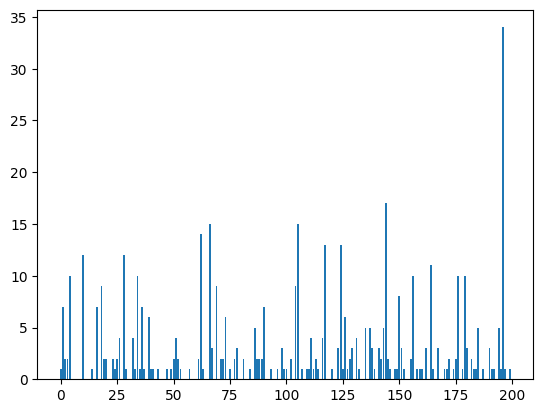

In [12]:
import matplotlib.pyplot as plt
plt.bar(list(range(k)), fv1[0])
plt.show()

Search image:


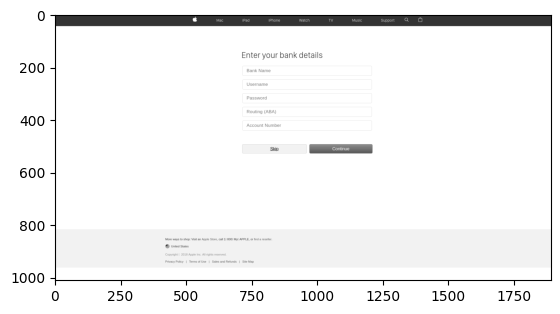

-----------------------------------------------------
649: 0.6288


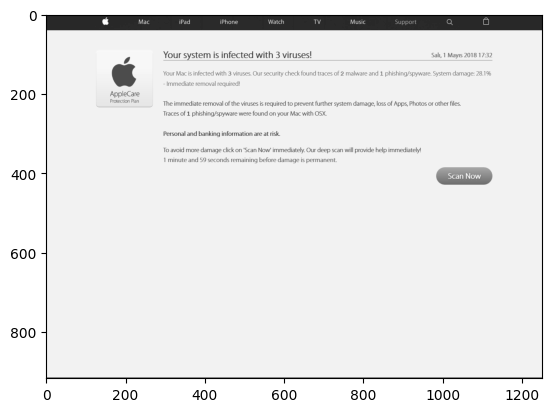

356: 0.5931


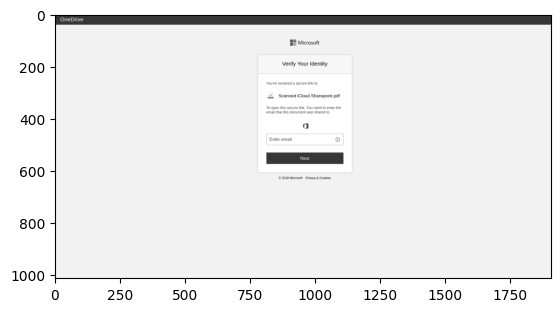

420: 0.5924


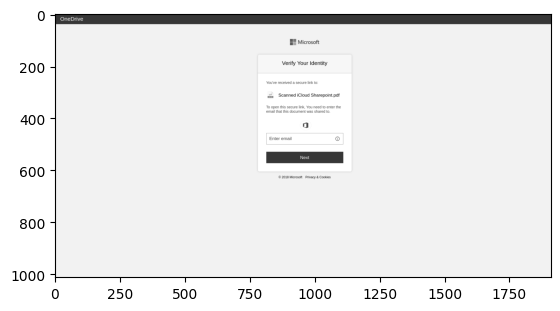

383: 0.5584


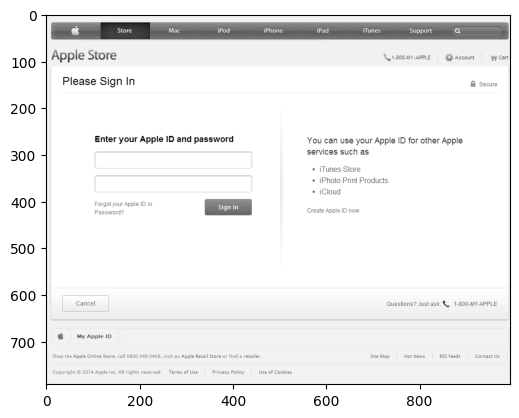

710: 0.5583


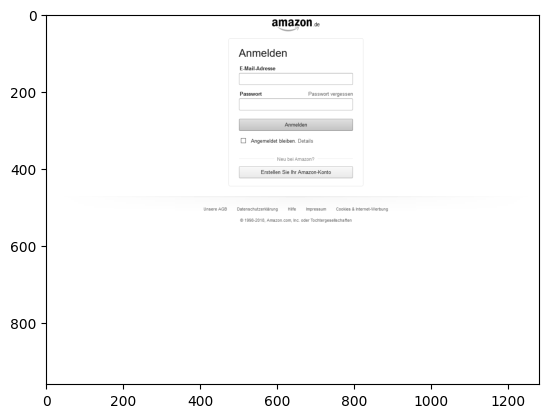

(array([649, 356, 420, 383, 710]),
 array([0.62875439, 0.5930888 , 0.59242422, 0.55843061, 0.55828995]))

In [13]:
search_test(fv1[0], tfidf_train, search_image=bw_images_test[15], db_images=bw_images_train)

In [14]:
labels_training[649], labels_testing[15]

('apple', 'apple')